## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_shared_experience"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields
                          and field != ftc_key)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,...,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000,337622.000000
mean,0.624552,0.437395,0.102304,0.059699,0.451084,0.117719,0.345188,0.195619,0.174335,0.194088,...,0.059326,0.142913,0.099805,0.163898,0.011090,0.018899,0.009748,0.018319,0.130478,0.109384
std,0.437780,0.449509,0.295037,0.228783,0.185295,0.067458,0.180828,0.166907,0.179850,0.183331,...,0.131795,0.163397,0.128994,0.186203,0.050795,0.076307,0.052162,0.082945,0.111360,0.107209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.315863,0.075257,0.214402,0.093156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045767,0.028655
50%,0.888889,0.333333,0.000000,0.000000,0.462660,0.075257,0.345861,0.147648,0.144661,0.130824,...,0.000000,0.070165,0.000000,0.077533,0.000000,0.000000,0.000000,0.000000,0.103029,0.078081
75%,1.000000,0.943182,0.000000,0.000000,0.584878,0.150513,0.481673,0.309457,0.289322,0.303764,...,0.000000,0.251540,0.178763,0.295197,0.000000,0.000000,0.000000,0.000000,0.187627,0.159210
max,1.000000,1.000000,1.000000,1.000000,0.988177,0.993329,0.993892,0.771833,0.952475,1.000000,...,1.000000,1.000000,0.854348,0.886728,1.000000,1.000000,0.999796,1.000000,0.917726,0.915254


In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

print(f'{len(train)=}, {len(test)=}')

train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]

test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

class_counts = test_dependent.value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(class_imbalance)

len(train)=270097, len(test)=67525
5.702233250620347


## Model Creation

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series
):
    # Model creation and predictions.
    random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [4]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(
    _df: pd.DataFrame,
    predictor_fields: Iterator[str],
    k: int = 5
):
    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        rf_model, rf_metrics = create_model(
            train_predictors,
            train_labels,
            test_predictors,
            test_labels
        )
        # return rf_model, rf_metrics['f1']
        return rf_metrics

    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=seed_counter.get_next()
    )
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 8),
        return_results=True
    )

    # TODO: support this.
    # rf_models = [entry[0] for entry in models_and_f1s]
    # f1_scores = [entry[1] for entry in models_and_f1s]
    f1_scores = [entry['f1'] for entry in models_and_f1s]

    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return None, f1_scores, f1_mean, f1_std


In [5]:
full_rf_models, f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, independent_fields)

print("\nPerformance metrics full model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

SimpleConsumer-0 started.
SimpleConsumer-1 started.
SimpleConsumer-2 started.
SimpleConsumer-3 started.
SimpleConsumer-4 started.
random_state=44
random_state=44
random_state=44
random_state=44
random_state=44
metrics={'accuracy': 0.9058274713069233, 'precision': 0.9207229748637837, 'recall': 0.9731540121094022, 'f1': 0.9462127299640516}

Confusion matrix:
[[ 5233  4816]
 [ 1543 55933]]

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.52      0.62     10049
        True       0.92      0.97      0.95     57476

    accuracy                           0.91     67525
   macro avg       0.85      0.75      0.78     67525
weighted avg       0.90      0.91      0.90     67525

SimpleConsumer-0: Received termination task.
SimpleConsumer-0: Stopped.
metrics={'accuracy': 0.903545406077839, 'precision': 0.9180433277277673, 'recall': 0.9730537352555702, 'f1': 0.9447484284732649}

Confusion matrix:
[[ 5328  4971]
 [ 1542 55683]]

Classif

### control + intra

In [6]:
# Creates control model + Intra fields.
contr_with_intra = [field for field in independent_fields
                    if re.match(r'.*(Control|Intra).*',field)]
contr_with_intra = list(contr_with_intra)
print(contr_with_intra)
control_rf_models, f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)
print("\nPerformance metrics control + intra model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
SimpleConsumer-0 started.
SimpleConsumer-1 started.
SimpleConsumer-2 started.
SimpleConsumer-3 started.
SimpleConsumer-4 started.
random_state=45
random_state=45random_state=45

random_state=45
random_state=45
metrics={'accuracy': 0.8913439466864125, 'precision': 0.9145456658531321, 'recall': 0.9617627544784719, 'f1': 0.9375601038253691}

Confusion matrix:
[[ 5104  5147]
 [ 2190 55084]]

Classification report:
              prec

### Collab + eco

In [10]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in independent_fields
                               if not re.match(r'.*(Intra|Control).*', field)]
non_control_fields_wo_intra = list(non_control_fields_wo_intra)
print(non_control_fields_wo_intra)
_, f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_fields_wo_intra)
print("\nPerformance metrics non-control model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)', 'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)', 'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)', 'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)', 'ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystem

## Partial Dependence Plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        used_labels: pd.Series,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


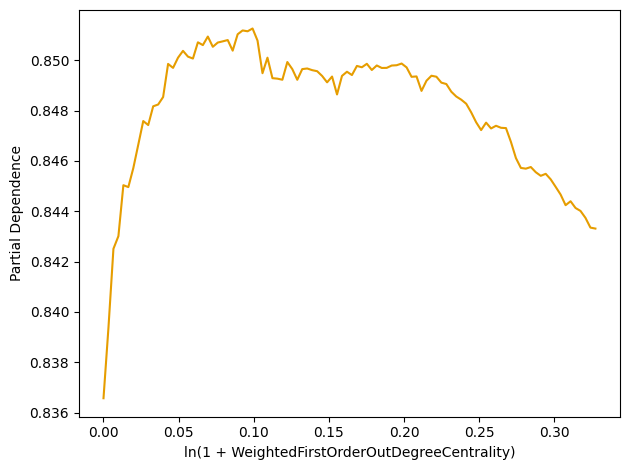

In [ ]:
full_rf_model, _ = create_model(
    train_predictors, train_dependent,
    test_predictors, test_dependent
)

create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    test_dependent,
    model_name="full_model"
)


### Mean Decrease in Accuracy

In [ ]:
full_rf_model = full_rf_models[0]
feature_importances = full_rf_model.feature_importances_    

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease Accuracy')
plt.title('Mean Decrease Accuracy of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')